In [168]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [169]:
# Import the Csv's
payments_df = pd.read_csv('/mnt/c/Users/kpali/Downloads/Payments.csv')
clients_df = pd.read_csv('/mnt/c/Users/kpali/Downloads/Clients.csv')

In [170]:
# Shape of each dataset
print(payments_df.shape)
print(clients_df.shape)

(25559, 6)
(1287, 3)


In [171]:
# Data types of each column
print(payments_df.dtypes)
print(clients_df.dtypes)

transaction_id        int64
contract_id           int64
client_id             int64
transaction_date      int64
payment_amt         float64
payment_code         object
dtype: object
client_id                   int64
entity_type                object
entity_year_established     int64
dtype: object


In [172]:
# Number of nulls in columns for each dataframe
payments_df_null_counts = payments_df.isnull().sum()
clients_df_null_counts = clients_df.isnull().sum()
print(payments_df_null_counts)
print(clients_df_null_counts)

transaction_id      0
contract_id         0
client_id           0
transaction_date    0
payment_amt         0
payment_code        0
dtype: int64
client_id                  0
entity_type                0
entity_year_established    0
dtype: int64


In [173]:
# Check there are no payment_amt less than 0
(payments_df['payment_amt'] < 0).sum()

2

In [174]:
# Rows with payment_amt < 0
payments_df[payments_df['payment_amt'] < 0]

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code
5271,16270,564,259,1522778905,-55.00,PAYMENT
20089,18574,451,937,1525370908,-136.66,PAYMENT


In [175]:
# Filter records with payment_amt >= 0
payments_df = payments_df[payments_df['payment_amt'] >= 0]

In [176]:
# Convert epoch timestamp for transaction_date to a month-year timestamp
payments_df['transaction_date'] = pd.to_datetime(payments_df['transaction_date'], unit = 's')

In [177]:
# Preview payments_df
payments_df.head()

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code
0,20175,927,1,2018-05-22 18:08:31,66.66,PAYMENT
1,8485,927,1,2017-11-26 17:08:15,66.66,PAYMENT
2,13778,927,1,2018-02-22 17:08:23,66.66,PAYMENT
3,22768,927,1,2018-06-24 18:08:44,66.66,PAYMENT
4,15698,927,1,2018-03-22 17:08:24,66.66,PAYMENT


In [178]:
# Explore contents of columns + records in each column for payments_df
print('Counts for each type of payment_code value: ')
print(payments_df['payment_code'].value_counts())
print(' ')
print('Counts of records by transaction date: ')
print(payments_df['transaction_date'].dt.strftime(date_format='%Y-%m').value_counts())
print(' ')
print('Summary statistics for payment_amt: ')
print(payments_df['payment_amt'].describe())
print(' ')
print('Number of contracts: ')
print(payments_df['contract_id'].nunique())
print(' ')
print('Number of unique clients: ')
print(payments_df['client_id'].nunique())

Counts for each type of payment_code value: 
payment_code
PAYMENT    23338
DEFAULT     2219
Name: count, dtype: int64
 
Counts of records by transaction date: 
transaction_date
2018-06    2469
2018-05    2429
2018-04    2271
2018-07    2245
2018-03    1917
2018-02    1905
2017-07    1884
2018-01    1871
2017-08    1759
2017-11    1751
2017-10    1742
2017-12    1661
2017-09    1653
Name: count, dtype: int64
 
Summary statistics for payment_amt: 
count     25557.000000
mean       1221.558777
std        4346.203781
min           0.010000
25%          93.330000
50%         266.660000
75%         833.330000
max      200000.050000
Name: payment_amt, dtype: float64
 
Number of contracts: 
1643
 
Number of unique clients: 
1281


In [179]:
# Explore contents of columns + records in each column for clients_df
print('Counts of businesses by entity_type: ')
print(clients_df['entity_type'].value_counts())
print(' ')
print('Counts of businesses by year established: ')
print(clients_df['entity_year_established'].value_counts())

Counts of businesses by entity_type: 
entity_type
Australian Private Company        754
Individual/Sole Trader            457
Family Partnership                 39
Discretionary Trading Trust        12
Other Partnership                  10
Australian Public Company           6
Fixed Unit Trust                    4
Discretionary Investment Trust      3
Australian Proprietary Company      1
Hybrid Trust                        1
Name: count, dtype: int64
 
Counts of businesses by year established: 
entity_year_established
2000    167
2014    122
2015    117
2016    101
2013     94
2012     86
2011     68
2010     61
2008     55
2007     55
2009     49
2006     49
2005     46
2017     45
2003     43
2004     34
2001     34
1999     29
2002     26
2018      6
Name: count, dtype: int64


In [180]:
# Join the two dataframes into a single dataframe joining on 'client id' column
merged_df = pd.merge(payments_df, clients_df, on='client_id')
merged_df.head()

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code,entity_type,entity_year_established
0,20175,927,1,2018-05-22 18:08:31,66.66,PAYMENT,Other Partnership,2006
1,8485,927,1,2017-11-26 17:08:15,66.66,PAYMENT,Other Partnership,2006
2,13778,927,1,2018-02-22 17:08:23,66.66,PAYMENT,Other Partnership,2006
3,22768,927,1,2018-06-24 18:08:44,66.66,PAYMENT,Other Partnership,2006
4,15698,927,1,2018-03-22 17:08:24,66.66,PAYMENT,Other Partnership,2006


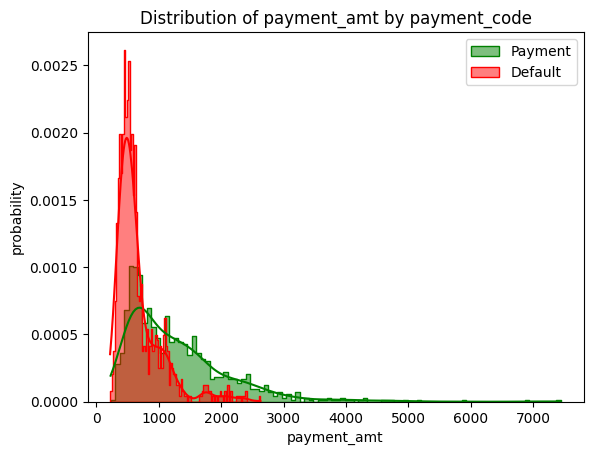

In [181]:
# Is there a statistical difference between payments with payment_code == 'PAYMENT' and payment_code == 'DEFAULT'
payment_df = merged_df[merged_df['payment_code'] == 'PAYMENT']
default_df = merged_df[merged_df['payment_code'] == 'DEFAULT']

# Generate random samples and calculate sample means for each dataframe
'''Payments have strong right skewed distribution, sampling is required to ensure a normal distribution of means to compare to ensure compliance with Central Limit Theorem (CLT)'''
sample_size = 30
num_samples = 1000
payment_samples = [payment_df['payment_amt'].sample(sample_size, replace=True) for _ in range(num_samples)]
default_samples = [default_df['payment_amt'].sample(sample_size, replace=True) for _ in range(num_samples)]
payment_means = [sample.mean() for sample in payment_samples]
default_means = [sample.mean() for sample in default_samples]

# Plot Distributions
sns.histplot(payment_means, bins=100, kde=True, color='green', label='Payment', element='step', stat='density')
sns.histplot(default_means, bins=100, kde=True, color='red', label='Default', element='step', stat='density')
plt.xlabel('payment_amt')
plt.ylabel('probability')
plt.title('Distribution of payment_amt by payment_code')
plt.legend()

plt.show()


In [182]:
# Summary statistics for payments with payment_code = 'PAYMENT' and payment_code = 'DEFAULT'
payment_series = pd.Series(payment_means)
default_series = pd.Series(default_means)
print("Payment distribution", payment_series.describe(), sep ='\n')
print("Default distribution", default_series.describe(), sep ='\n')

Payment distribution
count    1000.000000
mean     1280.840010
std       829.521571
min       226.106333
25%       666.491917
50%      1091.692667
75%      1633.164250
max      7444.664333
dtype: float64
Default distribution
count    1000.000000
mean      661.782768
std       364.547951
min       217.944333
25%       437.515833
50%       543.050000
75%       748.225833
max      2626.795333
dtype: float64


In [183]:
# Is a certain entity_type more likely to have a payment_code = 'DEFAULT' compared to another?
default_by_entity_type_df = merged_df.groupby('entity_type').agg(
    percent_default=('payment_code', lambda x: (x == 'DEFAULT').mean() * 100),
    transactions_count=('payment_code', 'count')).reset_index()
default_by_entity_type_df


,entity_type,percent_default,transactions_count
0,Australian Private Company,8.195524,15057
1,Australian Proprietary Company,0.000000,4
2,Australian Public Company,12.500000,128
3,Discretionary Investment Trust,18.548387,124
4,Discretionary Trading Trust,11.229947,187
5,Family Partnership,4.483696,736
6,Fixed Unit Trust,0.000000,32
7,Hybrid Trust,6.250000,32
8,Individual/Sole Trader,9.567803,9417
9,Other Partnership,4.444444,135


In [184]:
# Comparison of mode of entity_year_established by entity_type where payment_code = 'DEFAULT' and payment_code = 'SUCCESS'
mode_entity_year_established_default_by_entity_type_df = merged_df[merged_df['payment_code'] == 'DEFAULT'].groupby('entity_type')['entity_year_established'].apply(lambda x: x.mode())
mode_entity_year_established_default_by_entity_type_df.columns = ['entity_type', 'mode_entity_year_established']
mode_entity_year_established_payment_by_entity_type_df = merged_df[merged_df['payment_code'] == 'PAYMENT'].groupby('entity_type')['entity_year_established'].apply(lambda x: x.mode())
mode_entity_year_established_payment_by_entity_type_df.columns = ['entity_type', 'mode_entity_year_established']
merged_mode_entity_year_established_df = pd.merge(mode_entity_year_established_default_by_entity_type_df, mode_entity_year_established_payment_by_entity_type_df, on='entity_type', suffixes=('_DEFAULT', '_PAYMENT'))
merged_mode_entity_year_established_df

,entity_year_established_DEFAULT,entity_year_established_PAYMENT
entity_type,,
Australian Private Company,2015,2000
Australian Public Company,2013,2013
Discretionary Investment Trust,2015,2016
Discretionary Trading Trust,2013,2007
Family Partnership,2011,2000
Hybrid Trust,2007,2007
Individual/Sole Trader,2014,2000
Other Partnership,2000,2000


In [185]:
# Number of contracts before failure
sorted_merged_df = merged_df.sort_values(by=['client_id', 'contract_id', 'transaction_date']).reset_index()
sorted_merged_df.head(20)

,index,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code,entity_type,entity_year_established
0,6,8322,927,1,2017-11-22 17:08:16,5050.04,PAYMENT,Other Partnership,2006
1,9,8323,927,1,2017-11-22 17:08:16,50.00,PAYMENT,Other Partnership,2006
2,1,8485,927,1,2017-11-26 17:08:15,66.66,PAYMENT,Other Partnership,2006
3,7,8484,927,1,2017-11-26 17:08:15,466.67,PAYMENT,Other Partnership,2006
4,15,10126,927,1,2017-12-21 17:08:22,66.66,PAYMENT,Other Partnership,2006
5,16,10125,927,1,2017-12-21 17:08:22,416.67,PAYMENT,Other Partnership,2006
6,2,13778,927,1,2018-02-22 17:08:23,66.66,PAYMENT,Other Partnership,2006
7,12,13777,927,1,2018-02-22 17:08:23,416.67,PAYMENT,Other Partnership,2006
8,4,15698,927,1,2018-03-22 17:08:24,66.66,PAYMENT,Other Partnership,2006
9,13,15697,927,1,2018-03-22 17:08:24,416.67,PAYMENT,Other Partnership,2006


In [186]:
# Produce dataframe with only no default payments fo client_id that has at least one default
default_client_ids = sorted_merged_df[sorted_merged_df['payment_code'] == 'DEFAULT']['client_id'].unique()
default_client_ids_df = sorted_merged_df[sorted_merged_df['client_id'].isin(default_client_ids)].reset_index()
default_client_ids_df.head(30)

,level_0,index,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code,entity_type,entity_year_established
0,96,121,6161,836,7,2017-10-16 17:08:14,5050.04,PAYMENT,Australian Private Company,2015
1,97,122,6162,836,7,2017-10-16 17:08:14,50.00,PAYMENT,Australian Private Company,2015
2,98,117,6375,836,7,2017-10-19 17:08:10,66.66,PAYMENT,Australian Private Company,2015
3,99,124,6374,836,7,2017-10-19 17:08:10,466.67,PAYMENT,Australian Private Company,2015
4,100,104,7940,836,7,2017-11-16 17:08:17,66.66,PAYMENT,Australian Private Company,2015
5,101,113,7939,836,7,2017-11-16 17:08:17,416.67,PAYMENT,Australian Private Company,2015
6,102,96,9648,836,7,2017-12-17 17:08:18,66.66,PAYMENT,Australian Private Company,2015
7,103,103,9647,836,7,2017-12-17 17:08:18,416.67,PAYMENT,Australian Private Company,2015
8,104,116,11457,836,7,2018-01-16 17:08:19,416.67,PAYMENT,Australian Private Company,2015
9,105,123,11458,836,7,2018-01-16 17:08:19,66.66,PAYMENT,Australian Private Company,2015


In [187]:
filtered_df = default_client_ids_df.groupby(['entity_type', 'contract_id']).apply(lambda x: x.loc[:x[x['payment_code'] == 'DEFAULT'].index[0]-1] if 'DEFAULT' in x['payment_code'].values else x)
filtered_df.head(20)

/tmp/ipykernel_1005/415803894.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = default_client_ids_df.groupby(['entity_type', 'contract_id']).apply(lambda x: x.loc[:x[x['payment_code'] == 'DEFAULT'].index[0]-1] if 'DEFAULT' in x['payment_code'].values else x)


level_0  index  transaction_id  \
entity_type                contract_id                                        
Australian Private Company 5           5108    11685  11700             142   
                                       5109    11686  11694            1294   
                                       5110    11687  11688            2508   
                                       5111    11688  11706            3349   
                                       5112    11689  11708            4010   
                                       5113    11690  11692            4887   
                                       5114    11691  11701            5603   
                                       5115    11692  11704            6412   
                                       5116    11693  11707            7164   
                                       5117    11694  11709            7981   
                                       5118    11695  11686            8796   
                                       5119    11696  11691            9570   
                                       5120    11697  11696           10451   
                                       5121    11698  11698           10527   
                           7           8662    19204  19233            1284   
                                       8663    19205  19213            1563   
                                       8664    19206  19218            1882   
                                       8665    19207  19219            1883   
                           9           3052     7070   7071           15224   
                           13          5133    11842  11842              44   

                                             contract_id  client_id  \
entity_type                contract_id                                
Australian Private Company 5           5108            5        545   
                                       5109            5        545   
                                       5110            5        545   
                                       5111            5        545   
                                       5112            5        545   
                                       5113            5        545   
                                       5114            5        545   
                                       5115            5        545   
                                       5116            5        545   
                                       5117            5        545   
                                       5118            5        545   
                                       5119            5        545   
                                       5120            5        545   
                                       5121            5        545   
                           7           8662            7        885   
                                       8663            7        885   
                                       8664            7        885   
                                       8665            7        885   
                           9           3052            9        335   
                           13          5133           13        553   

                                               transaction_date  payment_amt  \
entity_type                contract_id                                         
Australian Private Company 5           5108 2017-07-03 18:08:05       300.00   
                                       5109 2017-07-23 18:08:31       300.00   
                                       5110 2017-08-13 18:08:59       300.00   
                                       5111 2017-08-27 18:09:19       300.00   
                                       5112 2017-09-10 18:09:34       300.00   
                                       5113 2017-09-24 18:08:09       300.00   
                                       5114 2017-10-08 17:08:12       300.00   
                       

Text(0.5, 1.0, 'Mean number of transactions Before DEFAULT by entity_type')

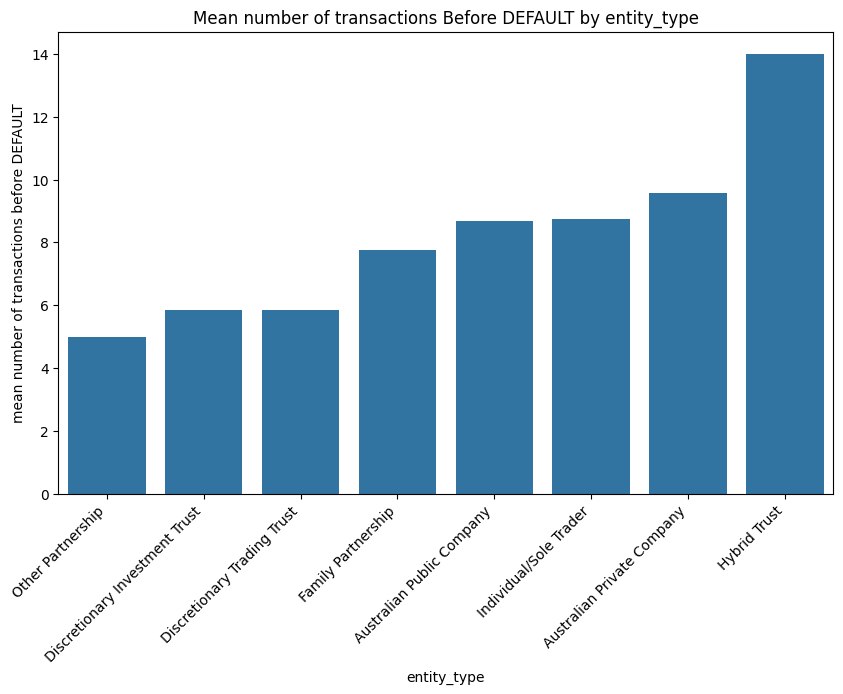

In [204]:
# Mean number of records before DEFAULT transaction by entity type
records_per_contract_by_entity_type = filtered_df.reset_index(drop = True).groupby(['entity_type', 'contract_id']).size()
mean_records_per_contract_by_entity_type = records_per_contract_by_entity_type.groupby('entity_type').mean().reset_index()
mean_records_per_contract_by_entity_type.columns = ['entity_type', 'mean number of transactions before DEFAULT']
mean_records_per_contract_by_entity_type_sorted = mean_records_per_contract_by_entity_type.sort_values(by='mean number of transactions before DEFAULT')
plt.figure(figsize=(10, 6))
sns.barplot(x='entity_type', y='mean number of transactions before DEFAULT', data=mean_records_per_contract_by_entity_type_sorted)
plt.xticks(rotation=45, ha='right')
plt.title('Mean number of transactions Before DEFAULT by entity_type')

/tmp/ipykernel_1005/2992211670.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  default_clients_ids_payment_df['transaction_date'] = default_clients_ids_payment_df['transaction_date'].dt.to_period('M')
/tmp/ipykernel_1005/2992211670.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  default_clients_ids_default_df['transaction_date'] = default_clients_ids_default_df['transaction_date'].dt.to_period('M')


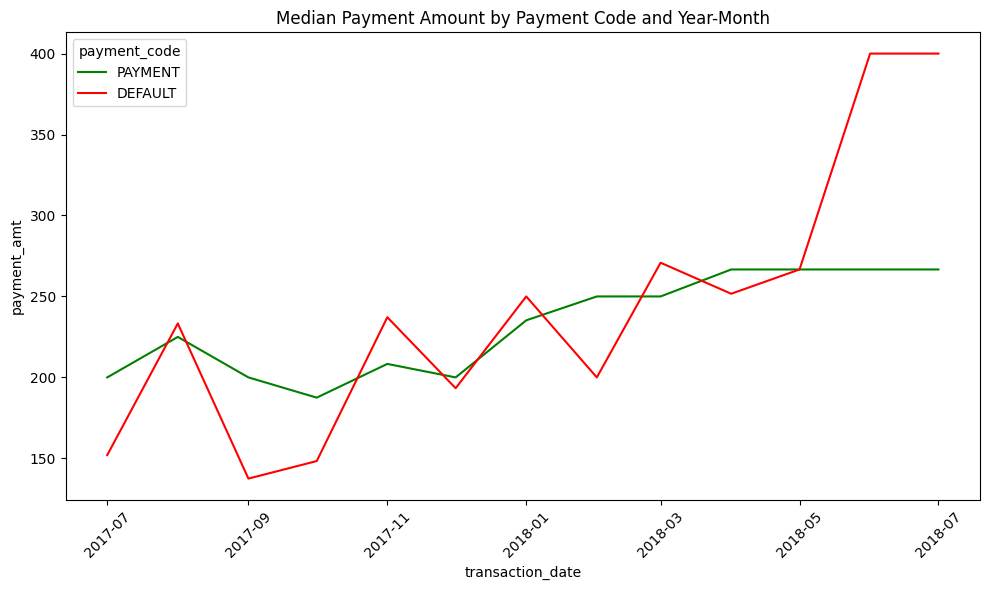

In [226]:
# Median payment amount payment_code = 'PAYMENT' and payment_code = 'DEFAULT' for client_id's that have at least one default transaction
default_client_ids = sorted_merged_df[sorted_merged_df['payment_code'] == 'DEFAULT']['client_id'].unique()
default_client_ids_df = sorted_merged_df[sorted_merged_df['client_id'].isin(default_client_ids)].reset_index()
default_clients_ids_payment_df = default_client_ids_df[default_client_ids_df['payment_code'] == 'PAYMENT']
default_clients_ids_default_df = default_client_ids_df[default_client_ids_df['payment_code'] == 'DEFAULT']
default_clients_ids_payment_df['transaction_date'] = default_clients_ids_payment_df['transaction_date'].dt.to_period('M')
default_clients_ids_default_df['transaction_date'] = default_clients_ids_default_df['transaction_date'].dt.to_period('M')
median_payment_amt_payment = default_clients_ids_payment_df.groupby(['payment_code', 'transaction_date'])['payment_amt'].median().reset_index()
median_payment_amt_default = default_clients_ids_default_df.groupby(['payment_code', 'transaction_date'])['payment_amt'].median().reset_index()
median_payment_amt_df = pd.concat([median_payment_amt_payment, median_payment_amt_default], ignore_index=True)
median_payment_amt_df['transaction_date'] = median_payment_amt_df['transaction_date'].dt.to_timestamp()
custom_palette = {'PAYMENT': 'green', 'DEFAULT': 'red'}
plt.figure(figsize=(10, 6))
sns.lineplot(x='transaction_date', y='payment_amt', hue='payment_code', palette=custom_palette, data=median_payment_amt_df)
plt.title('Median Payment Amount by Payment Code and Year-Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [253]:
# Length of contract and likelihood of having default transaction
default_contract_ids = sorted_merged_df[sorted_merged_df['payment_code'] == 'DEFAULT']['contract_id'].unique()
default_contract_ids_df = sorted_merged_df[sorted_merged_df['client_id'].isin(default_contract_ids)].reset_index()
payment_contract_ids_df = sorted_merged_df[~sorted_merged_df['client_id'].isin(default_contract_ids)].reset_index()
default_contract_ids_df = default_contract_ids_df.groupby('contract_id')['transaction_date'].agg(['min', 'max'])
payment_contract_ids_df = payment_contract_ids_df.groupby('contract_id')['transaction_date'].agg(['min', 'max'])
default_contract_ids_df['contract_length'] = (default_contract_ids_df['max'] - default_contract_ids_df['min'])  / pd.Timedelta(days=1)
payment_contract_ids_df['contract_length'] = (payment_contract_ids_df['max'] - payment_contract_ids_df['min'])  / pd.Timedelta(days=1)
print('Distribution of contract lengths for contracts with payment = "DEFAULT"', default_contract_ids_df['contract_length'].describe(), sep='\n')
print('Distribution of contract lengths for contracts with payment = "PAYMENT"', payment_contract_ids_df['contract_length'].describe(), sep='\n')

Distribution of contract lengths for contracts with payment = "DEFAULT"
count    448.000000
mean     155.862927
std      114.157848
min        0.000000
25%       60.000463
50%      151.042350
75%      259.260443
max      379.000868
Name: contract_length, dtype: float64
Distribution of contract lengths for contracts with payment = "PAYMENT"
count    1195.000000
mean      145.553267
std       110.974325
min         0.000000
25%        41.000625
50%       123.041470
75%       242.978866
max       385.000023
Name: contract_length, dtype: float64


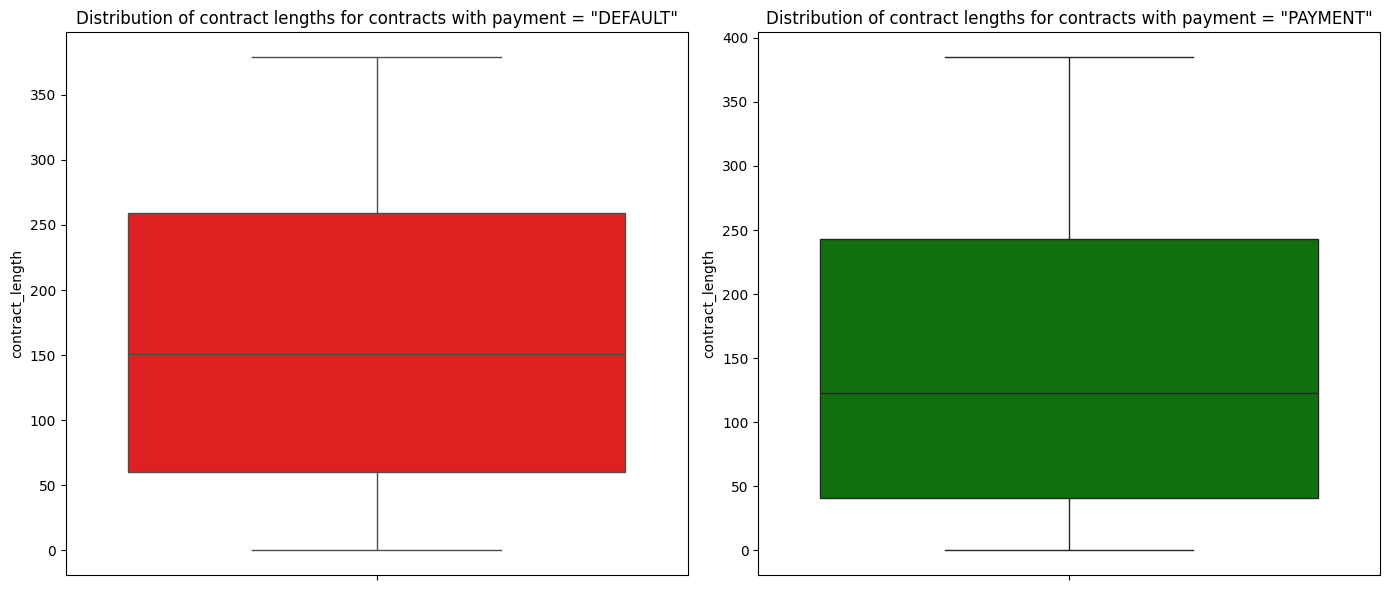

In [263]:
fig,axes = plt.subplots(1,2, figsize=(14, 6))
sns.boxplot(y='contract_length', data=default_contract_ids_df, color='red', ax=axes[0])
axes[0].set_title('Distribution of contract lengths for contracts with payment = "DEFAULT"')
sns.boxplot(y='contract_length', data=payment_contract_ids_df, color='green', ax=axes[1])
axes[1].set_title('Distribution of contract lengths for contracts with payment = "PAYMENT"')
plt.tight_layout()
plt.show()

<Axes: xlabel='status', ylabel='payment_amt'>

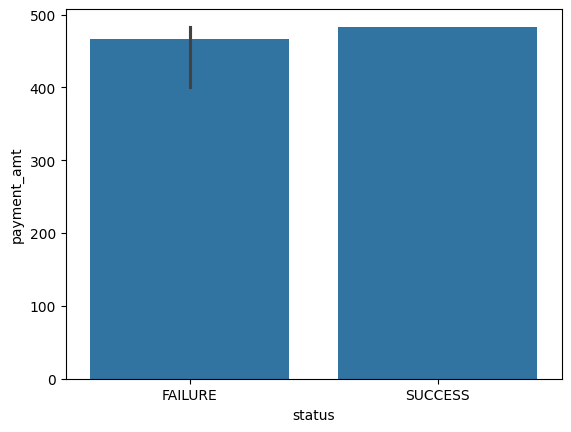

In [252]:
# Median transaction amounts for contract with no default payments vs with
default_contract_ids = sorted_merged_df[sorted_merged_df['payment_code'] == 'DEFAULT']['contract_id'].unique()
default_contract_ids_df = sorted_merged_df[sorted_merged_df['client_id'].isin(default_contract_ids)].reset_index()
payment_contract_ids_df = sorted_merged_df[~sorted_merged_df['client_id'].isin(default_contract_ids)].reset_index()
default_contract_ids_df = default_contract_ids_df.groupby('contract_id')['payment_amt'].agg('median').reset_index()
payment_contract_ids_df = payment_contract_ids_df.groupby('contract_id')['payment_amt'].agg('median').reset_index()
default_contract_ids_df['status'] = 'FAILURE'
payment_contract_ids_df['status'] = 'SUCCESS'
median_payment_amt_df = pd.concat([default_contract_ids_df, payment_contract_ids_df], ignore_index=True)
sns.barplot(x='status', y='payment_amt', data=median_payment_amt_df, estimator=np.median)
